#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, random
from typing import Tuple

In [18]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def pairwise(iterable):
  a = iter(iterable)
  return zip(a, a)

In [43]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      self._array = np.array([randint(0, 1) for _ in range(length)])
    else:
      self._array = array
    self._length = length

  def decode(self, lower_bound: int, upper_bound: int, aoi: Tuple[float, float]):
      bits = upper_bound - lower_bound
      encoded_value = 0
      for i in range(bits):
        encoded_value += self._array[lower_bound+i]*pow(2, bits-i-1)
      return min_max_norm(encoded_value, 0, pow(2, bits), *aoi)

  def mutation(self, probability):
    if random() < probability:
      gene_index = randint(0, self._length-1)
      self._array[gene_index] = int(not(self._array[gene_index]))

  def crossover(self, other: 'Chromosome'):
    assert self._length == other._length

    crossover_index = randint(0, self._length-1)
    first_chromosome_array = np.empty((self._length, 1))
    second_chromosome_array = np.empty((self._length, 1))

    for i in range(crossover_index):
      first_chromosome_array[i] = self._array[i]
      second_chromosome_array[i] = other._array[i]

    for i in range(crossover_index, self._length):
      first_chromosome_array[i] = other._array[i]
      second_chromosome_array[i] = self._array[i]

    child1 = Chromosome(self._length, first_chromosome_array)
    child2 = Chromosome(self._length, second_chromosome_array)
    return child1, child2

In [130]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self._chromosome_lengths = chromosome_length
    self._obj_func_num_args = obj_func_num_args
    self._bits_per_arg = int(chromosome_length / obj_func_num_args)
    self._objective_function = objective_function
    self._aoi = aoi
    self._tournament_size = tournament_size
    self._mutation_probability = mutation_probability
    self._crossover_probability = crossover_probability
    self._num_steps = num_steps
    self._population_size = population_size
    self._trace = []

  def get_arguments(self, chromosome: 'Chromosome'):
    arguments = []
    for i in range(self._obj_func_num_args):
      value = float(chromosome.decode(i*self._bits_per_arg, (i+1)*self._bits_per_arg, self._aoi))
      arguments.append(value)
    return arguments

  def eval_objective_func(self, chromosome: 'Chromosome'):
    return self._objective_function(*self.get_arguments(chromosome))

  def tournament_selection(self, population):
    chosen_individuals = np.random.choice(population, self._tournament_size)
    evaluations = [self.eval_objective_func(individual) for individual in chosen_individuals]
    winner = evaluations.index(min(evaluations))
    return chosen_individuals[winner]

  def reproduce(self, population):
    # Select individuals to ttournament_selectionhe temporary generation using tournament selection
    r_generation = [self.tournament_selection(population) for _ in range(self._population_size)]

    new_generation = []
    for parent1, parent2 in pairwise(r_generation):
      # Crossover parents with given probability, otherwise move them to the next generation
      if random() < self._crossover_probability:
        child1, child2 = parent1.crossover(parent2)
        new_generation += [child1, child2]
      else:
        new_generation += [parent1, parent2]

    # Mutate new generation with given probability
    for individual in new_generation:
      individual.mutation(self._mutation_probability)

    return new_generation

  def find_best(self, population, evaluations):
    best_evaluation = min(evaluations)
    best_evaluation_index = evaluations.index(best_evaluation)
    best_individual = population[best_evaluation_index]
    return best_individual, best_evaluation

  def plot_func(self, trace):
    X = np.arange(-1, 1, 0.05)
    Y = np.arange(-1, 1, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = self._objective_function(X, Y)
    #Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    population = [Chromosome(self._chromosome_lengths) for _ in range(self._population_size)]
    evaluations = [self.eval_objective_func(individual) for individual in population]
    best_individual, best_evaluation = self.find_best(population, evaluations)
    self._trace = []
    self._trace.append(self.get_arguments(best_individual))
    for i in range(self._num_steps):
      new_generation = self.reproduce(population)
      evaluations = [self.eval_objective_func(individual) for individual in new_generation]
      step_best_individual, step_best_evaluation = self.find_best(new_generation, evaluations)
      if step_best_evaluation <= best_evaluation:
        best_evaluation = step_best_evaluation
        best_individual = step_best_individual
        self._trace.append(self.get_arguments(best_individual))
      population = new_generation
      print(f"Epoch: {i}\tArguments: {self.get_arguments(best_individual)}\tValue: {self.eval_objective_func(best_individual)}\t Error: {abs(self._objective_function(0, 0) - self.eval_objective_func(best_individual))}")

    self.plot_func(self._trace)
    return best_individual

In [21]:
g = lambda x, y: 1.5 - np.exp(-x**2-y**2) - 0.5*np.exp(-(x-1)**2-(y+2)**2)

In [145]:
algorithm = GeneticAlgorithm(200, 2, g, [-100, 100], population_size=200, num_steps=1000)
best = algorithm.run()

/var/folders/vx/whxlny2j6qb0v1vsvk9gx_680000gn/T/ipykernel_45697/1968869673.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(chromosome.decode(i*self.bits_per_arg, (i+1)*self.bits_per_arg, self.aoi))


Epoch: 0	Arguments: [3.013911590916308, 0.7631191328787708]	Value: 1.4999324121270976	 Error: 1.0033013856266404
Epoch: 1	Arguments: [3.013911590916308, 0.7631191328787708]	Value: 1.4999324121270976	 Error: 1.0033013856266404
Epoch: 2	Arguments: [3.013911590916308, 0.7631191328787708]	Value: 1.4999324121270976	 Error: 1.0033013856266404
Epoch: 3	Arguments: [2.7990964720919322, 0.7631193082308272]	Value: 1.4997694924808802	 Error: 1.003138465980423
Epoch: 4	Arguments: [2.7990964720919322, 0.7631193081637662]	Value: 1.499769492480854	 Error: 1.0031384659803968
Epoch: 5	Arguments: [2.7990964720919322, 0.7631193081637662]	Value: 1.499769492480854	 Error: 1.0031384659803968
Epoch: 6	Arguments: [2.4779254381983975, 0.7631193335992492]	Value: 1.4987692314773706	 Error: 1.0021382049769134
Epoch: 7	Arguments: [-0.7073045173420383, 0.7631202432722972]	Value: 1.1612840771493662	 Error: 0.664653050648909
Epoch: 8	Arguments: [-0.32590352557113533, 0.7631193335992492]	Value: 0.997661604576938	 Error

KeyboardInterrupt: 

In [68]:
best.decode(8, 16, [-10, 10])

array([0.])

In [76]:
f = lambda x, y: (x + 2*y - 7)**2 + (2*x + y - 5)**2

In [77]:
f(1, 3)

0

/var/folders/vx/whxlny2j6qb0v1vsvk9gx_680000gn/T/ipykernel_45697/1995509602.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(chromosome.decode(i*self.bits_per_arg, (i+1)*self.bits_per_arg, self.aoi))


Epoch: 0	Arguments: [3.4827840328216553, 2.290388345718384]	Value: 19.244326389595813	 Error: 54.75567361040419
Epoch: 1	Arguments: [3.4827840328216553, 2.2903859615325928]	Value: 19.24429595273716	 Error: 54.75570404726284
Epoch: 2	Arguments: [3.4827840328216553, 2.2561514377593994]	Value: 18.813113520561387	 Error: 55.18688647943861
Epoch: 3	Arguments: [3.4827840328216553, 2.2561514377593994]	Value: 18.813113520561387	 Error: 55.18688647943861
Epoch: 4	Arguments: [2.1546590328216553, 2.2903859615325928]	Value: 2.629049753665754	 Error: 71.37095024633425
Epoch: 5	Arguments: [2.1546590328216553, 2.2903859615325928]	Value: 2.629049753665754	 Error: 71.37095024633425
Epoch: 6	Arguments: [2.1546590328216553, 2.2561514377593994]	Value: 2.5616091365801594	 Error: 71.43839086341984
Epoch: 7	Arguments: [2.1546590328216553, 2.2559010982513428]	Value: 2.5611591425669076	 Error: 71.43884085743309
Epoch: 8	Arguments: [2.0765340328216553, 2.2559010982513428]	Value: 2.1546611648929	 Error: 71.84533

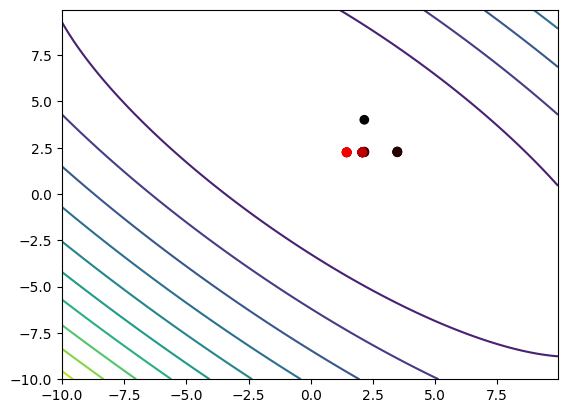

In [115]:
algorithm2 = GeneticAlgorithm(48, 2, f, [-10, 10], population_size=10)
algorithm2.run()